In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt

/kaggle/input/volatility-smile-prediction/test_data.parquet
/kaggle/input/volatility-smile-prediction/sample_submission.csv
/kaggle/input/volatility-smile-prediction/train_data.parquet


# Loading Dataset, X and y

In [4]:
data_path = '/kaggle/input/volatility-smile-prediction'
output_path = '/kaggle/working'
temp_path = '/kaggle/temp'

In [5]:
# Load the train data
train_df = pd.read_parquet(f'{data_path}/train_data.parquet')
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
print((train_df.shape))
print(train_df.columns)

(178340, 97)
Index(['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600',
       'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000',
       'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400',
       'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800',
       'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200',
       'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600',
       'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000',
       'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800',
       'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200',
       'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600',
       'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000',
       'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400',
       'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800',
       'put_iv_24900', 'put_iv_25

In [6]:
iv_cols = [col for col in train_df.columns if col.startswith('call_iv_') or col.startswith('put_iv_')]

# Create a boolean mask for valid rows (all IV values between 0 and 100 inclusive)
valid_rows_mask = ~((train_df[iv_cols] < 0) | (train_df[iv_cols] > 10)).any(axis=1)

# Apply mask to filter the DataFrame
clean_df = train_df[valid_rows_mask].copy()

print(f"Removed {len(train_df) - len(clean_df)} invalid rows.")

Removed 299 invalid rows.


In [7]:
train_df = clean_df

In [14]:
import warnings

# Load the test data
test_df = pd.read_parquet(f'{data_path}/test_data.parquet')

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    test_df.head(5)

In [7]:
X = clean_df.drop(columns=iv_cols)
y = clean_df[iv_cols]

In [8]:
X['timestamp'] = pd.to_datetime(X['timestamp'])
X['expiry'] = pd.to_datetime(X['expiry'])
# X['days_to_expiry'] = (X['expiry'] - X['timestamp']).dt.days
X = X.drop(columns=['timestamp', 'expiry'])

# Random Forest Regressor

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(RandomForestRegressor(random_state=0))
%time model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

# Plotting curves for analysis

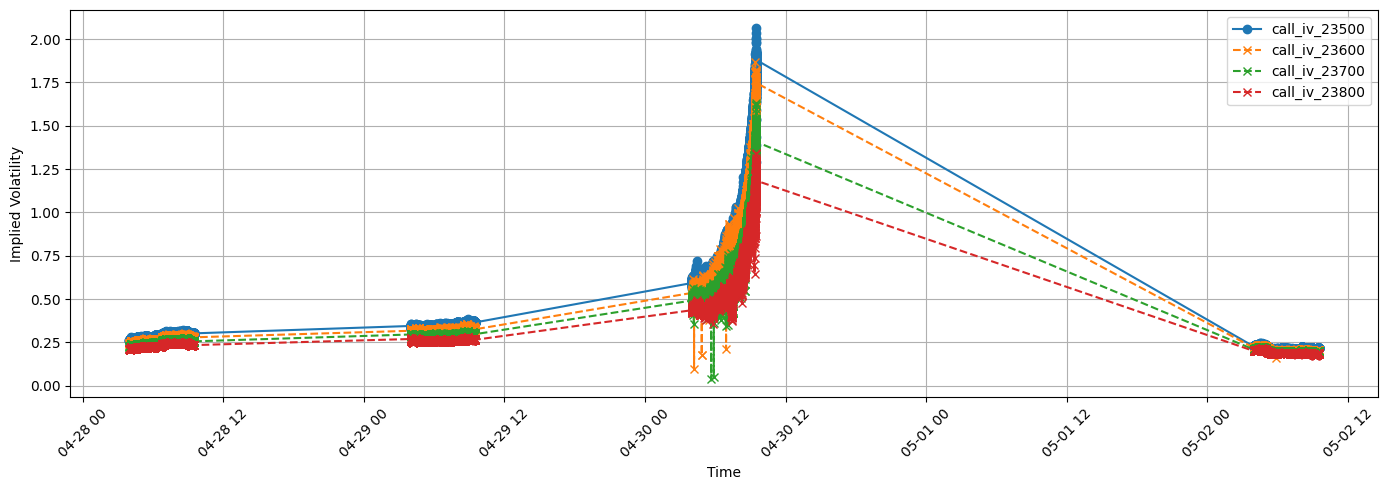

In [10]:
# Ensure 'timestamp' is datetime
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

# Filter for April 23 and 24, 2025
mask = (train_df['timestamp'].dt.date >= pd.to_datetime('2025-04-28').date()) & \
       (train_df['timestamp'].dt.date <= pd.to_datetime('2025-05-02').date())

filtered_df = train_df.loc[mask]

# Plot
plt.figure(figsize=(14, 5))
plt.plot(filtered_df['timestamp'], filtered_df['call_iv_23500'], marker='o', linestyle='-', label='call_iv_23500')
plt.plot(filtered_df['timestamp'], filtered_df['call_iv_23600'], marker='x', linestyle='--', label='call_iv_23600')
plt.plot(filtered_df['timestamp'], filtered_df['call_iv_23700'], marker='x', linestyle='--', label='call_iv_23700')
plt.plot(filtered_df['timestamp'], filtered_df['call_iv_23800'], marker='x', linestyle='--', label='call_iv_23800')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


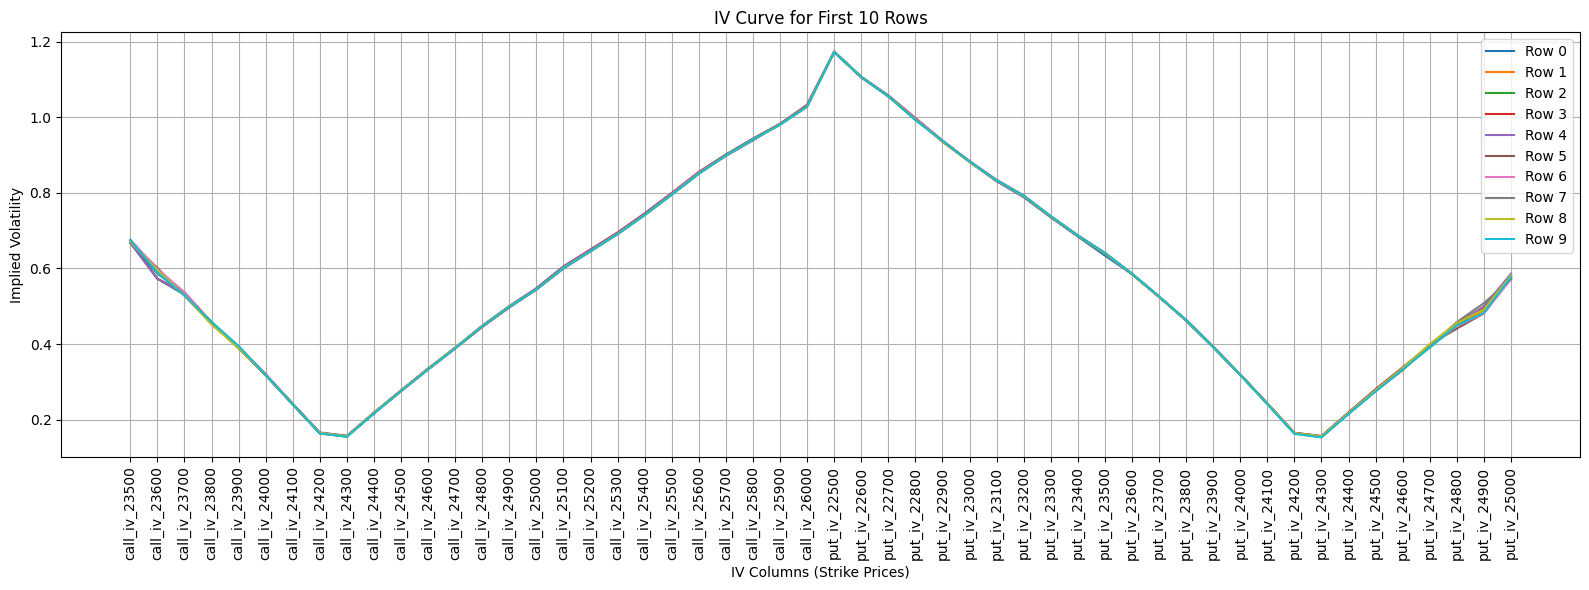

In [11]:
import matplotlib.pyplot as plt

# Select IV columns
iv_cols = [col for col in train_df.columns if col.startswith('call_iv_') or col.startswith('put_iv_')]

# Take first 10 rows
subset = train_df[iv_cols].head(10)

# Plot each row as a line
plt.figure(figsize=(16, 6))
for i in range(len(subset)):
    plt.plot(iv_cols, subset.iloc[i], label=f'Row {i}')

plt.xlabel('IV Columns (Strike Prices)')
plt.ylabel('Implied Volatility')
plt.title('IV Curve for First 10 Rows')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


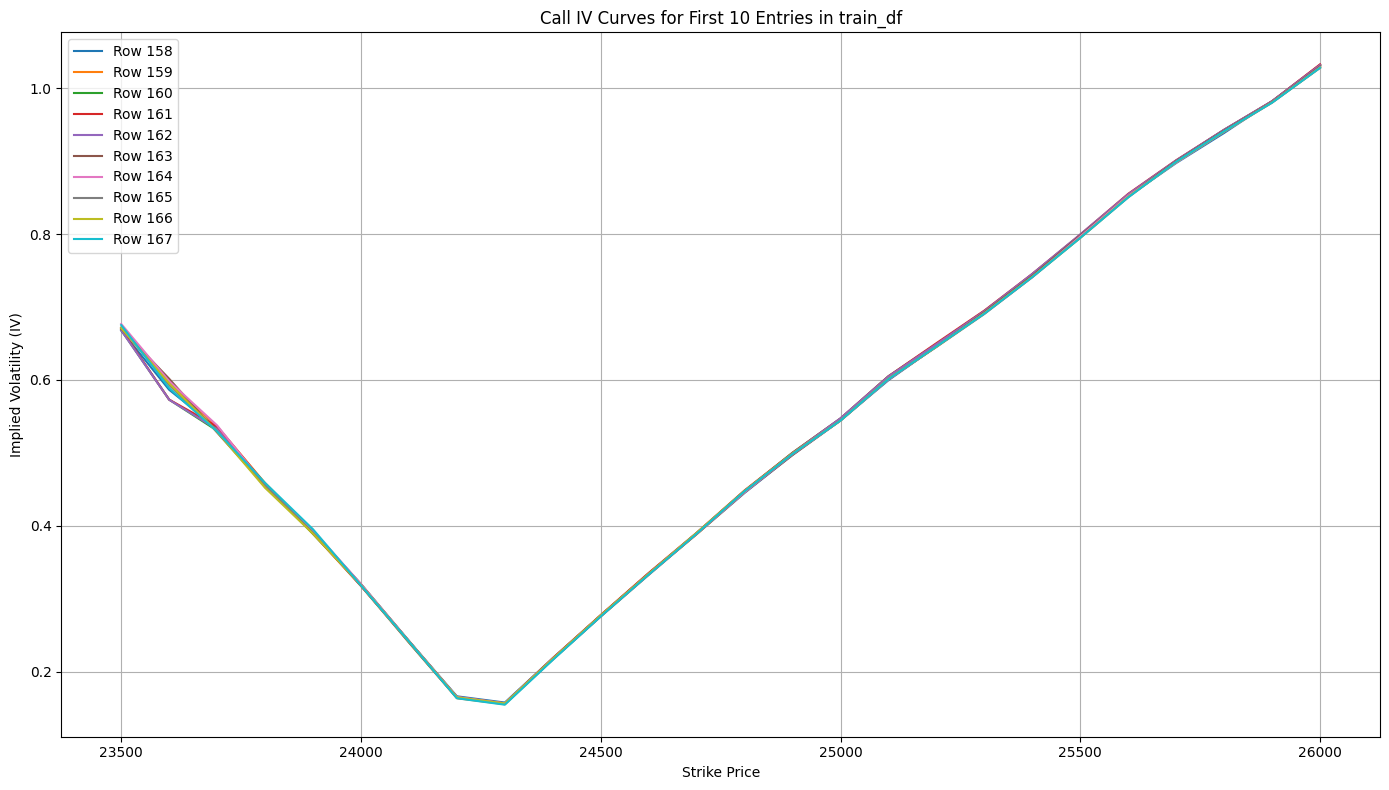

158    24265.9
159    24266.3
160    24265.1
161    24264.8
162    24266.8
163    24268.4
164    24268.1
165    24267.8
166    24268.3
167    24268.7
Name: underlying, dtype: float64


In [8]:
import matplotlib.pyplot as plt

# List of call IV columns
call_iv_cols = [col for col in train_df.columns if col.startswith('call_iv_')]
put_iv_cols = [col for col in train_df.columns if col.startswith('put_iv_')]

# call_iv_cols = call_iv_cols[:]

# Extract the first 10 entries for the selected columns
subset = train_df[call_iv_cols].head(10)

# Plotting
plt.figure(figsize=(14, 8))
for idx, row in subset.iterrows():
    plt.plot([int(col.split('_')[-1]) for col in call_iv_cols], row, label=f'Row {idx}')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (IV)')
plt.title('Call IV Curves for First 10 Entries in train_df')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(train_df['underlying'].head(10))

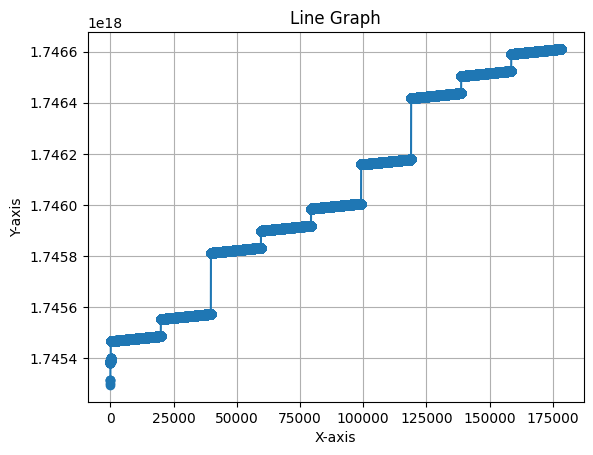

In [35]:
train_df['log_call_iv_23700'] = np.log(train_df['call_iv_23700'])

# Plot
plt.plot(range(len(train_df['timestamp'])), train_df['timestamp'], marker='o')
plt.title("Line Graph")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()

# PCA for reducing multi-collinearity

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


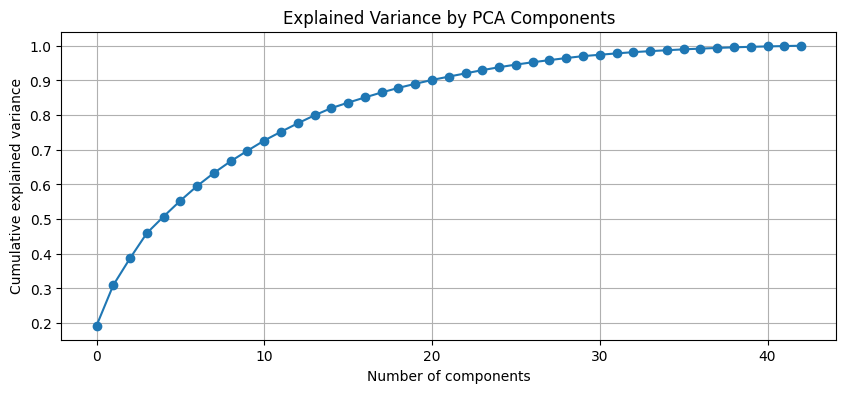

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.title("Explained Variance by PCA Components")
plt.show()


In [17]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95)
print(f"Number of components explaining 95% variance: {n_components}")

Number of components explaining 95% variance: 27


In [21]:
loading_matrix = pca.components_.T  # shape: (n_features, n_components)
feature_importance = np.abs(loading_matrix[:, :n_components]).sum(axis=1)
feature_scores = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

# Top 20 most influential original features
top_features = feature_scores.head(20)
print(top_features)


# KMeans Clustering
adding `train_df['market_regime']` column <br>
adding `test_df['market_regime']` column

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Select features for regime detection (e.g., technical indicators, returns)
x_cols = [col for col in train_df.columns if 'X' in col]

# 2. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df[x_cols])

# 3. (Optional but recommended) Reduce dimensionality with PCA
pca = PCA(n_components=28, random_state=42)  # or any number that retains most variance
X_reduced = pca.fit_transform(X_scaled)

# 4. KMeans Clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# 5. Assign market regime labels
train_df['market_regime'] = clusters

In [ ]:
# Repeat the same preprocessing on test_df
X_test_scaled = scaler.transform(test_df[x_cols])
X_test_reduced = pca.transform(X_test_scaled)

# Predict market regimes
test_df['market_regime'] = kmeans.predict(X_test_reduced)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.histplot(data=train_df, x='market_regime', discrete=True, shrink=0.8)
plt.title('Histogram of Market Regimes')
plt.xlabel('Market Regime')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.histplot(data=test_df, x='market_regime', discrete=True, shrink=0.8)
plt.title('Histogram of Market Regimes')
plt.xlabel('Market Regime')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Experiments with Test Data - Random Forest Regressor

In [18]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# Load the test data
test_df = pd.read_parquet(f'{data_path}/test_data.parquet')
test_df.head(5)

,timestamp,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,24735.9,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,...,0.006587,0.002826,-1.737617e+05,-0.009541,-0.017831,0.000264,2.032521e+06,1.000000e-06,-0.077238,-5.362742e+06
1,1,24766.7,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,NaN,...,0.005777,0.004588,-3.195086e+05,-0.024106,-0.004696,-0.000158,-4.529075e+06,-1.619022e+06,-0.956928,4.624907e+06
2,2,24896.9,NaN,0.251731,NaN,NaN,0.214869,0.20458,0.194604,NaN,...,0.000829,-0.034944,1.027525e+06,0.028201,0.032234,0.007687,2.663908e+06,0.000000e+00,-0.116264,-2.669766e+06
3,3,24898.1,0.241888,NaN,0.220505,NaN,0.198602,0.18619,NaN,NaN,...,-0.009323,-0.022969,-4.720074e+06,-0.001513,0.008704,-0.000206,-7.672936e+06,-1.903406e+06,-2.249208,-1.858254e+07
4,4,24906.5,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,...,-0.018674,-0.007588,-4.051681e+05,-0.136267,0.002425,-0.002200,1.334469e+06,2.548789e+05,1.999104,3.024212e+06


In [21]:
from sklearn.ensemble import RandomForestRegressor

def predict_missing_iv(df, target_iv):
    print(f'predicted {target_iv}')
    df_train = df[df[target_iv].notna()]
    df_test = df[df[target_iv].isna()]
    
    if df_train.shape[0] < 10:
        return df  # not enough data to train

    feature_cols = [col for col in df.columns if col != target_iv and df[col].isna().sum() == 0]
    X_train = df_train[feature_cols]
    y_train = df_train[target_iv]
    X_test = df_test[feature_cols]
    
    model = RandomForestRegressor(n_estimators=50, random_state=0)
    model.fit(X_train, y_train)

    df.loc[df[target_iv].isna(), target_iv] = model.predict(X_test)
    return df

# Apply for each IV column with NaNs
iv_cols = [col for col in test_df.columns if col.startswith('call_iv_') or col.startswith('put_iv_')]
for iv in iv_cols:
    if test_df[iv].isna().sum() > 0:
        test_df = predict_missing_iv(test_df, iv)


predicted call_iv_24000
predicted call_iv_24100
predicted call_iv_24200
predicted call_iv_24300
predicted call_iv_24400
predicted call_iv_24500
predicted call_iv_24600
predicted call_iv_24700
predicted call_iv_24800
predicted call_iv_24900
predicted call_iv_25000
predicted call_iv_25100
predicted call_iv_25200
predicted call_iv_25300
predicted call_iv_25400
predicted call_iv_25500
predicted call_iv_25600
predicted call_iv_25700
predicted call_iv_25800
predicted call_iv_25900
predicted call_iv_26000
predicted call_iv_26100
predicted call_iv_26200
predicted call_iv_26300
predicted call_iv_26400
predicted call_iv_26500
predicted put_iv_23000
predicted put_iv_23100
predicted put_iv_23200
predicted put_iv_23300
predicted put_iv_23400
predicted put_iv_23500
predicted put_iv_23600
predicted put_iv_23700
predicted put_iv_23800
predicted put_iv_23900
predicted put_iv_24000
predicted put_iv_24100
predicted put_iv_24200
predicted put_iv_24300
predicted put_iv_24400
predicted put_iv_24500
predicte

In [ ]:
submission_df = test_df['timestamp' + iv_cols]
submission_df.to_csv(f'{output_path}/submission.csv', index = False)

# Experiments in Test Data - XGBoost
Imputation in test data <br>
Predicting NANs in test data using non-NANs in test data itself

In [24]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

def predict_missing_iv_xgb(df, target_iv):
    # Rows where target_iv is not NaN (for training)
    df_train = df[df[target_iv].notna()]
    df_test = df[df[target_iv].isna()]

    top_feature_names = top_features.index.tolist()
    feature_cols = top_feature_names
    
    # Remove any feature columns that are completely NaN
    df_train = df_train[feature_cols + [target_iv]].dropna()
    X_train = df_train[feature_cols]
    y_train = df_train[target_iv]
    X_test = df_test[feature_cols]

    model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict and fill
    df.loc[df[target_iv].isna(), target_iv] = model.predict(X_test)
    return df

In [26]:
iv_cols = [col for col in test_df.columns if (col.startswith('call_iv_') or col.startswith('put_iv_'))]

for iv_col in iv_cols:
    if test_df[iv_col].isna().sum() > 0:
        print(f"Imputing: {iv_col}")
        test_df = predict_missing_iv_xgb(test_df, iv_col)

Imputing: call_iv_24300
Imputing: call_iv_24400
Imputing: call_iv_24500
Imputing: call_iv_24600
Imputing: call_iv_24700
Imputing: call_iv_24800
Imputing: call_iv_24900
Imputing: call_iv_25000
Imputing: call_iv_25100
Imputing: call_iv_25200
Imputing: call_iv_25300
Imputing: call_iv_25400
Imputing: call_iv_25500
Imputing: call_iv_25600
Imputing: call_iv_25700
Imputing: call_iv_25800
Imputing: call_iv_25900
Imputing: call_iv_26000
Imputing: call_iv_26100
Imputing: call_iv_26200
Imputing: call_iv_26300
Imputing: call_iv_26400
Imputing: call_iv_26500
Imputing: put_iv_23000
Imputing: put_iv_23100
Imputing: put_iv_23200
Imputing: put_iv_23300
Imputing: put_iv_23400
Imputing: put_iv_23500
Imputing: put_iv_23600
Imputing: put_iv_23700
Imputing: put_iv_23800
Imputing: put_iv_23900
Imputing: put_iv_24000
Imputing: put_iv_24100
Imputing: put_iv_24200
Imputing: put_iv_24300
Imputing: put_iv_24400
Imputing: put_iv_24500
Imputing: put_iv_24600
Imputing: put_iv_24700
Imputing: put_iv_24800
Imputing: p

In [30]:
test_df[iv_cols].head(10)

,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,call_iv_24900,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0.280939,0.255234,0.250780,0.236388,0.242149,0.206975,0.232439,0.205267,0.222997,0.227966,...,0.232334,0.192409,0.196441,0.227301,0.234169,0.215854,0.250422,0.214298,0.216722,0.282229
1,0.270276,0.268041,0.258893,0.226669,0.215078,0.207895,0.233548,0.194851,0.193809,0.229917,...,0.201021,0.228209,0.189405,0.193939,0.190347,0.249402,0.204143,0.209604,0.211269,0.228768
2,0.259036,0.251731,0.244415,0.227204,0.214869,0.204580,0.194604,0.203186,0.199794,0.180668,...,0.194612,0.188052,0.200931,0.191181,0.181346,0.196324,0.190750,0.206727,0.214984,0.216901
3,0.241888,0.234758,0.220505,0.221768,0.198602,0.186190,0.199023,0.190577,0.183539,0.180362,...,0.189758,0.166394,0.161561,0.190174,0.192139,0.172032,0.194063,0.207632,0.211765,0.206107
4,0.235328,0.229069,0.222983,0.214126,0.213039,0.205416,0.192603,0.212810,0.190219,0.189374,...,0.196522,0.193445,0.187239,0.177920,0.183701,0.176000,0.191354,0.204474,0.182314,0.208263
5,0.242357,0.236998,0.226874,0.222966,0.215642,0.214704,0.201546,0.197817,0.189387,0.181337,...,0.201276,0.190842,0.189407,0.181670,0.177992,0.193447,0.177270,0.199982,0.179433,0.207880
6,0.260927,0.263735,0.249609,0.239511,0.231006,0.217456,0.224797,0.221294,0.192065,0.200893,...,0.225048,0.196111,0.186564,0.199061,0.200024,0.199927,0.228963,0.221533,0.232356,0.271001
7,0.275760,0.283110,0.258581,0.228962,0.221339,0.238596,0.232301,0.203918,0.200669,0.196845,...,0.201874,0.222416,0.203831,0.221060,0.228808,0.237793,0.243166,0.252460,0.219623,0.238869
8,0.258057,0.245146,0.221020,0.232593,0.212560,0.202869,0.188084,0.195493,0.184405,0.194017,...,0.200650,0.192602,0.194598,0.192226,0.187707,0.173868,0.207573,0.179501,0.204332,0.218507
9,0.255974,0.229899,0.221718,0.214569,0.216124,0.199240,0.201213,0.194810,0.188342,0.185238,...,0.193230,0.195388,0.182182,0.187973,0.191272,0.176044,0.196774,0.178204,0.222242,0.211105


In [31]:
iv_df = test_df[iv_cols].copy()

# Add 0-indexed timestamp column
iv_df.insert(0, 'timestamp', range(len(iv_df)))

iv_df.to_csv("iv_predictions.csv", index=False)
